In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
import tensorflow_hub as hub
from keras.layers.core import Dense
from tensorflow.keras import layers
from keras.layers.core import Flatten

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,classification_report,precision_score,recall_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
# dataset: https://www.kaggle.com/datasets/meetnagadia/malaria-dataset 
# Keras Transfer Learning: https://keras.io/api/applications/

data_dir = ("/content/drive/MyDrive/Deep_Learning_Tutorials/Image Processing/Train with custom dataset/Malaria Classfication/Malaria")

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/Deep_Learning_Tutorials/Image Processing/Train with custom dataset/Malaria Classfication/Malaria')

In [ ]:
images = list(data_dir.glob('*/*.png'))
images[200]

PosixPath('/content/drive/MyDrive/Deep_Learning_Tutorials/Image Processing/Train with custom dataset/Malaria Classfication/Malaria/Uninfected/Uninfected_0_5215.png')

In [ ]:
#getting how many images I have
image_count = len(list(data_dir.glob('*/*.png')))       
print(image_count)

1200


In [ ]:
image_Uninfected = len(list(data_dir.glob('Uninfected/*')))
image_Parasite = len(list(data_dir.glob('Parasite/*')))


print("Total Count images for Uninfected: " + str(image_Uninfected))
print("Total Count images for Parasite: " + str(image_Parasite))


Total Count images for Uninfected: 633
Total Count images for Parasite: 567


Data Preparation

In [ ]:
# specify the images paths to have a class with a dictionary
malaria_images_dict = {
    'Uninfected': list(data_dir.glob('Uninfected/*')),
    'Parasite': list(data_dir.glob('Parasite/*')),

}

In [ ]:
# specify the classes to a number with a dictioanry 
malaria_labels_dict = {
   'Uninfected': 0,
    'Parasite': 1,
}

Visualize some of the Data

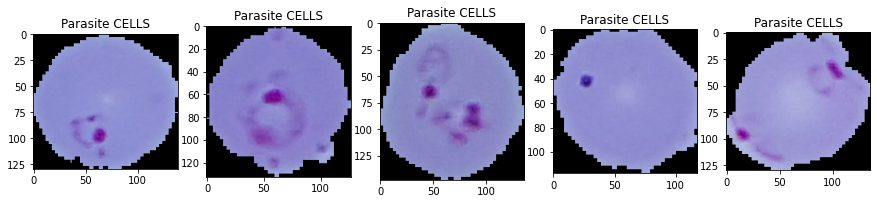

In [ ]:
# Visualize the Parasite Cells
plt.figure(figsize=(15,15))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(str(malaria_images_dict['Parasite'][i])))
    plt.title('Parasite CELLS')
    #plt.tight_layout()

plt.show()

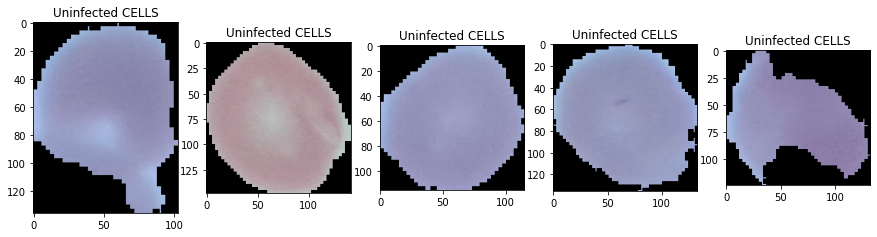

In [ ]:
# Visualize the Parasite Cells
plt.figure(figsize=(15,15))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(str(malaria_images_dict['Uninfected'][i])))
    plt.title('Uninfected CELLS')
    #plt.tight_layout()

plt.show()

Preprocessing: To GrayScale and Resizing image

In [ ]:
# Get X and Y values
X, y = [], []

# loop through the dictionaries
for malaria, images in malaria_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))    # read all images with paths
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # convert all images to grayscale
        resized_img = cv2.resize(img,(224,224)) # resize all images to 180 * 180
        X.append(resized_img)   
        y.append(malaria_labels_dict[malaria])



In [ ]:
# convert to array
X = np.array(X)
y = np.array(y)

In [ ]:
X[0].shape

(224, 224, 3)

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
X_train.shape
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#X_val.shape


Preprocessing: Normalization
Normalization is a common step of image pre-processing and is achieved by simply dividing x_train by 255.0 for the train dataset and x_test by 255.0 for the test dataset. This is essential to maintain the pixels of all the images within a uniform range.

In [ ]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
#X_train_scaled.reshape(-1)
#y_train.reshape(-1)


Improve Test Accuracy Using Data Augmentation Data Augmentation can create different samples from an original image such as:

RandomFlip
RandomZoom
RandomContrast etc

In [ ]:
data_augmentation = keras.Sequential(
  [

    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
   layers.RandomContrast(0.5)
  # layers.RandomContrast(1.0, seed=None)
   
  ]
)

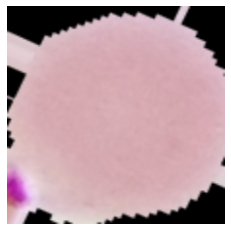

In [ ]:
plt.axis('off')
plt.imshow(X_train[201])

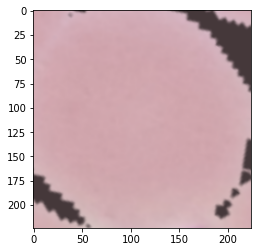

In [ ]:
plt.imshow(data_augmentation(X_train)[201].numpy().astype("uint8"))

Train CNN

In [ ]:
num_classes = 2   # we have 2 different classes from the dataset

cnn = Sequential([
   data_augmentation,

    layers.Conv2D(filters=16,  kernel_size=(3, 3), padding='same', activation='relu'), #the filters are random assign, kernel_size are assumed as 3 also known as the filter size,
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32,  kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64,  kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(num_classes,activation="softmax")
])

cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
cnn_history = cnn.fit(X_train_scaled, y_train, epochs=19)#,validation_data=(X_val, y_val)) 

Epoch 1/19


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/24 [==============================] - 4s 81ms/step - loss: 0.7885 - accuracy: 0.5182
Epoch 2/19
24/24 [==============================] - 2s 79ms/step - loss: 0.6141 - accuracy: 0.6328
Epoch 3/19
24/24 [==============================] - 2s 79ms/step - loss: 0.4891 - accuracy: 0.7500
Epoch 4/19
24/24 [==============================] - 2s 80ms/step - loss: 0.4658 - accuracy: 0.7852
Epoch 5/19
24/24 [==============================] - 2s 80ms/step - loss: 0.4004 - accuracy: 0.8099
Epoch 6/19
24/24 [==============================] - 2s 81ms/step - loss: 0.3894 - accuracy: 0.8268
Epoch 7/19
24/24 [==============================] - 2s 72ms/step - loss: 0.3226 - accuracy: 0.8646
Epoch 8/19
24/24 [==============================] - 2s 73ms/step - loss: 0.2955 - accuracy: 0.8815
Epoch 9/19
24/24 [==============================] - 2s 73ms/step - loss: 0.2396 - accuracy: 0.9193
Epoch 10/19
24/24 [==============================] - 2s 74ms/step - loss: 0.1910 - accuracy: 0.9284
Epoch 11/19
24/24 [=

1/8 [==>...........................] - ETA: 1s - loss: 0.0200 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 0s 33ms/step - loss: 0.0453 - accuracy: 0.9917
CNN Accuracy: 0.9916666746139526
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       130
           1       0.90      0.99      0.94       110

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



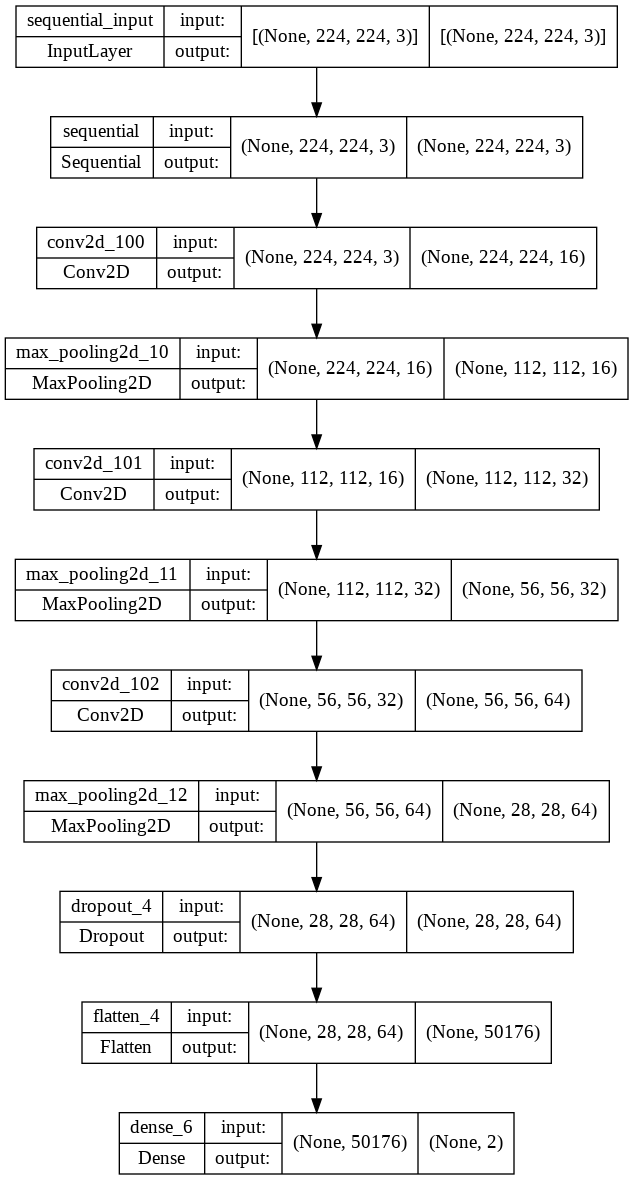

In [ ]:
cnn_score = cnn.evaluate(X_test_scaled,y_test)
print(f"CNN Accuracy: {cnn_score[1]}")

cnn_y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in cnn_y_pred]
print(classification_report(y_test, y_pred_classes))

plot_model(cnn, show_shapes=True, show_layer_names=True)


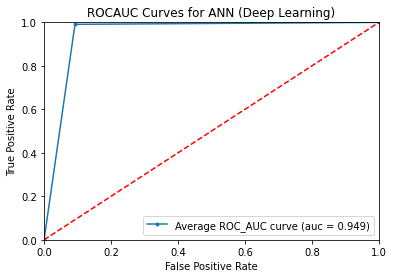

In [ ]:
y_predicted_labels = [np.argmax(i) for i in cnn_y_pred]
plt.title('ROCAUC Curves for CNN (Deep Learning)')

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_predicted_labels)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Average ROC_AUC curve (auc = %0.3f)' % auc_keras)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#cnn_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# Reference for plotting Loss for train and test set
# https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

'''
# summarize history for accuracy
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''

Confusion Matrix for CNN

Text(69.0, 0.5, 'Truth')

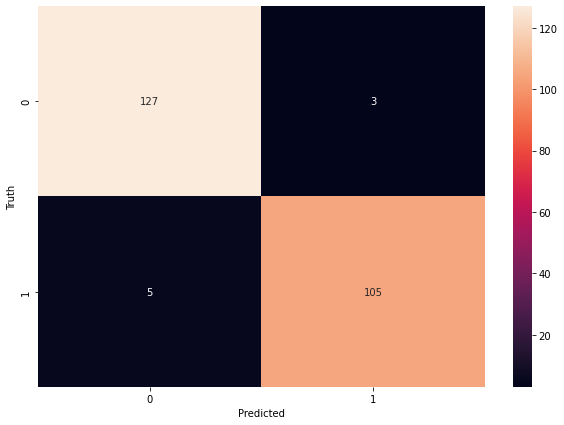

In [ ]:
y_predicted_labels = [np.argmax(i) for i in cnn_y_pred]

# Generate confusion matrix
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)
cm

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Transfer Learning with MobileNet

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
num_classes = 2   # we have 2 different classes from the dataset

mobilenet_model = tf.keras.Sequential([
  pretrained_model_without_top_layer,   # using the pretrained feature extractor 

    layers.Dense(51, activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),

    layers.Dense(num_classes,activation='softmax')       # specify the last layer to num of classes
])


mobilenet_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

mobilenet_model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 4s 40ms/step - loss: 0.2992 - accuracy: 0.8635
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0944 - accuracy: 0.9656
Epoch 3/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0816 - accuracy: 0.9688
Epoch 4/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0557 - accuracy: 0.9823
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0470 - accuracy: 0.9802
Epoch 6/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0409 - accuracy: 0.9854
Epoch 7/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0343 - accuracy: 0.9906
Epoch 8/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0344 - accuracy: 0.9906
Epoch 9/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0245 - accuracy: 0.9917
Epoch 10/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0172 - accuracy: 0.9948


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 1s 77ms/step - loss: 0.0355 - accuracy: 0.9833
MobileNet Accuracy: 0.9833333492279053
              precision    recall  f1-score   support

           0       0.59      0.96      0.73       130
           1       0.82      0.21      0.33       110

    accuracy                           0.62       240
   macro avg       0.71      0.59      0.53       240
weighted avg       0.70      0.62      0.55       240



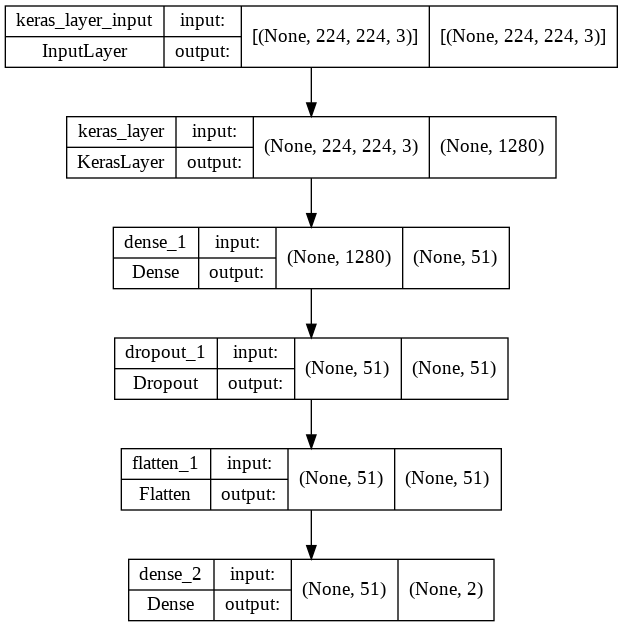

In [ ]:
mobilenet_score = mobilenet_model.evaluate(X_test_scaled,y_test)
print(f"MobileNet Accuracy: {mobilenet_score[1]}")

mobilenet_y_pred = mobilenet_model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in mobilenet_y_pred]
print(classification_report(y_test, y_pred_classes))


plot_model(mobilenet_model, show_shapes=True, show_layer_names=True)        #plotting the mobilenet model architecture


Train with InceptionV3
Inception train better with Data Augmentation increasing from 70+ to 80+%

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

inception_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)


inception_model = tf.keras.Sequential([
    input_tensor,
    data_augmentation,
    layers.Dense(25, activation='relu'),

    layers.Dropout(0.3),
    layers.Flatten(),

    layers.Dense(num_classes,activation='softmax')       # specify the last layer to num of classes
])

inception_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

inception_model.fit(X_train_scaled, y_train, epochs=10) 

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/24 [==============================] - 3s 87ms/step - loss: 13.3538 - accuracy: 0.6250
Epoch 2/10
24/24 [==============================] - 2s 85ms/step - loss: 5.8763 - accuracy: 0.7331
Epoch 3/10
24/24 [==============================] - 2s 85ms/step - loss: 2.9507 - accuracy: 0.8138
Epoch 4/10
24/24 [==============================] - 2s 85ms/step - loss: 2.3533 - accuracy: 0.8203
Epoch 5/10
24/24 [==============================] - 2s 85ms/step - loss: 2.5546 - accuracy: 0.8138
Epoch 6/10
24/24 [==============================] - 2s 84ms/step - loss: 1.6677 - accuracy: 0.8398
Epoch 7/10
24/24 [==============================] - 2s 84ms/step - loss: 2.6467 - accuracy: 0.8047
Epoch 8/10
24/24 [==============================] - 2s 85ms/step - loss: 5.3695 - accuracy: 0.7578
Epoch 9/10
24/24 [==============================] - 2s 86ms/step - loss: 5.8088 - accuracy: 0.7565
Epoch 10/10
24/24 [==============================] - 2s 84ms/step - loss: 4.2373 - accuracy: 0.7839


In [ ]:
inception_score = inception_model.evaluate(X_test_scaled,y_test)
print(f"InceptionV3 Accuracy: {inception_score[1]}")

inception_y_pred = inception_model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in inception_y_pred]
print(classification_report(y_test, y_pred_classes))


#plot_model(inception_model, show_shapes=True, show_layer_names=True)        #plotting the model architecture


1/8 [==>...........................] - ETA: 1s - loss: 1.7961 - accuracy: 0.9062

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 0s 37ms/step - loss: 1.7306 - accuracy: 0.8250
InceptionV3 Accuracy: 0.824999988079071
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       130
           1       0.73      0.86      0.79       110

    accuracy                           0.79       240
   macro avg       0.80      0.80      0.79       240
weighted avg       0.80      0.79      0.79       240



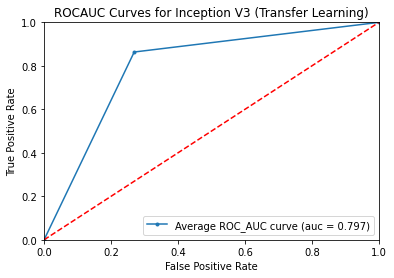

In [ ]:
y_predicted_labels = [np.argmax(i) for i in inception_y_pred]
plt.title('ROCAUC Curves for Inception V3 (Transfer Learning)')

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_predicted_labels)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Average ROC_AUC curve (auc = %0.3f)' % auc_keras)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Transfer Learning: VGG16 

VGG train better without data_augmentation

In [ ]:
from keras.applications.vgg16 import VGG16

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

VGG_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=True)


VGG_model = tf.keras.Sequential([
    input_tensor,
    #data_augmentation,
    layers.Dense(25, activation='relu'),

    layers.Dropout(0.2),
    layers.Flatten(),
    #layers.Flatten(),

    #layers.Dense(512, activation='relu'),

    #layers.Dropout(0.5),

    layers.Dense(num_classes,activation='softmax')       # specify the last layer to num of classes
])

VGG_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

VGG_model.fit(X_train_scaled, y_train, epochs=9) 

553476096/553467096 [==============================] - 7s 0us/step
Epoch 1/9


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/24 [==============================] - 4s 92ms/step - loss: 31.2832 - accuracy: 0.5365
Epoch 2/9
24/24 [==============================] - 2s 83ms/step - loss: 12.9188 - accuracy: 0.6224
Epoch 3/9
24/24 [==============================] - 2s 84ms/step - loss: 5.6691 - accuracy: 0.7708
Epoch 4/9
24/24 [==============================] - 2s 87ms/step - loss: 3.3464 - accuracy: 0.8177
Epoch 5/9
24/24 [==============================] - 2s 84ms/step - loss: 1.9676 - accuracy: 0.8659
Epoch 6/9
24/24 [==============================] - 2s 80ms/step - loss: 1.3355 - accuracy: 0.8659
Epoch 7/9
24/24 [==============================] - 2s 84ms/step - loss: 0.6306 - accuracy: 0.9206
Epoch 8/9
24/24 [==============================] - 2s 81ms/step - loss: 0.3534 - accuracy: 0.9388
Epoch 9/9
24/24 [==============================] - 2s 81ms/step - loss: 0.3527 - accuracy: 0.9388


In [ ]:
VGG_score = VGG_model.evaluate(X_test_scaled,y_test)
print(f"VGG16 Accuracy: {VGG_score[1]}")

VGG_y_pred = VGG_model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in VGG_y_pred]
print(classification_report(y_test, y_pred_classes))


#plot_model(inception_model, show_shapes=True, show_layer_names=True)        #plotting the model architecture


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 1s 34ms/step - loss: 1.0168 - accuracy: 0.8417
VGG16 Accuracy: 0.8416666388511658
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       130
           1       0.84      0.83      0.83       110

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



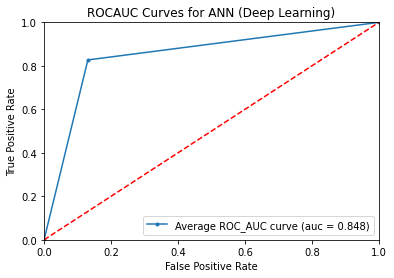

In [ ]:
y_predicted_labels = [np.argmax(i) for i in VGG_y_pred]
plt.title('ROCAUC Curves for VGG16 (Transfer Learning)')

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_predicted_labels)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Average ROC_AUC curve (auc = %0.3f)' % auc_keras)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Predicting CNN with Testing Data

In [ ]:
predictions = cnn.predict(X_test_scaled)


Parasite


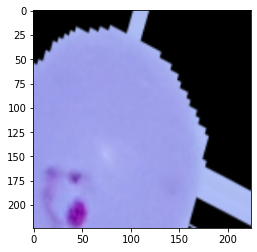

In [ ]:
plt.imshow(X_test[44])  #display image if want change image edit the [10] value
score = tf.nn.softmax(predictions[44])  # calculate score if want change image edit the [10] value
predicted_output = np.argmax(score)

if predicted_output == 0:
    print("Uninfected")
else:
    print("Parasite")

In [ ]:
!pip install lime


     |████████████████████████████████| 275 kB 13.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=37ae6f083015c1e201111955d5665c381d005bc17dfebd616d352f2720e01f6f
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


Parasite


  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 223.5, 223.5, -0.5)

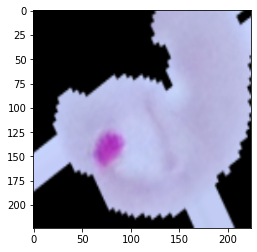

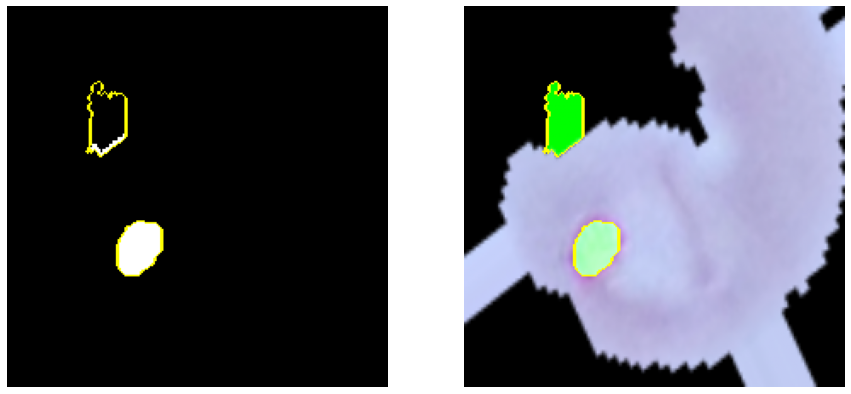

In [ ]:
#Reference: https://towardsdatascience.com/interpreting-image-classification-model-with-lime-1e7064a2f2e5 

ori = plt.imshow(X_test[51])  #display image if want change image edit the X_test[10] value
score = tf.nn.softmax(predictions[51])  # calculate score if want change image edit the X_test[10] value
predicted_output = np.argmax(score)

if predicted_output == 0:
    print("Uninfected")
else:
    print("Parasite")


from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(X_test[51], cnn.predict,       # edit image X_test[15]
                                         top_labels=3, hide_color=100)

from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=2, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')